In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

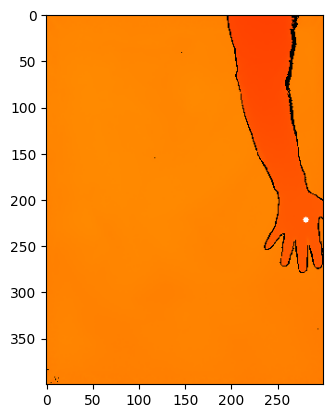

In [5]:
im = Image.open(f"Data/PNG_A/Images/OpenHand/1677.png")
im = np.array(im)
f = open(f"Data/PNG_A/Positions/OpenHand/1677.txt", "r")
xy = f.read().split()
x_pos = int(xy[0])
y_pos = int(xy[1])
f.close()

for x in range(300):
    for y in range(400):
        if((x - x_pos)**2 + (y - y_pos)**2 < 10):
            im[y][x] = [255, 255, 255]

import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()

In [2]:
def Bilinear(orig_image, new_width, new_height):
    new_x, new_y = np.meshgrid(np.arange(new_height), np.arange(new_width))
    orig_x = new_x / (new_width - 1) * (orig_image.shape[1] - 1)
    orig_y = new_y / (new_height - 1) * (orig_image.shape[0] - 1)
    x1 = orig_x.astype(int)
    y1 = orig_y.astype(int)
    x2 = np.clip(x1 + 1, 0, orig_image.shape[1] - 1)
    y2 = np.clip(y1 + 1, 0, orig_image.shape[0] - 1)
    dx = orig_x - x1
    dy = orig_y - y1
    dx = np.expand_dims(dx, axis=-1)
    dy = np.expand_dims(dy, axis=-1)
    result = (1 - dx) * (1 - dy) * orig_image[y1, x1] + \
             dx * (1 - dy) * orig_image[y1, x2] + \
             (1 - dx) * dy * orig_image[y2, x1] + \
             dx * dy * orig_image[y2, x2]
    return result.astype(np.uint8)

In [3]:
labels = ['NoHand','OpenHand','ClosedHand']
labels_pos = []
labels_ges = []
data = []
path = "Data/PNG_A/Images"
pos = "Data/PNG_A/Positions"
res = [300, 400]
for i in os.listdir(path):
    for j in os.listdir(path + "/" + i):
        im =  Image.open(path + "/" + i + '/' + j)
        im = np.array(im)
        im = Bilinear(im, 256, 256)
        im = im/255.0
        data.append(im)
        f = open(pos + "/" + i + "/" + j.split(".")[0] + ".txt", "r")
        temp = f.read().split()
        for k in range(2):
            cord = int(temp[k])
            if cord >= 0:
                temp[k] = cord/res[k]*256
            else:
                temp[k] = cord
        labels_pos.append(temp)
        labels_ges.append(labels.index(i))
        f.close()

data = np.array(data)
labels_pos = np.array(labels_pos)
labels_ges = tf.keras.utils.to_categorical(labels_ges)

print(data.shape)
print(labels_pos.shape)
print(labels_ges.shape)

(8000, 256, 256, 3)
(8000, 2)
(8000, 3)


In [4]:
from sklearn.model_selection import train_test_split

# Split the data for the position labels
data_train, data_val, labels_pos_train, labels_pos_val = train_test_split(data, labels_pos, train_size=0.80, random_state=42)

# Split the data for the gesture labels
_, _, labels_ges_train, labels_ges_val = train_test_split(data, labels_ges, train_size=0.80, random_state=42)

In [7]:
input = tf.keras.layers.Input(shape=(256, 256, 3))
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
f = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation='relu')(f)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
gesture_output = tf.keras.layers.Dense(3, activation='softmax', name="gesture_output")(x)

x = tf.keras.layers.Dense(256, activation='relu')(f)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
position_output = tf.keras.layers.Dense(2, name="position_output")(x)

model = tf.keras.Model(input, [gesture_output, position_output])

model.summary()

checkpoint_filepath = "checkpoints_position/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer='adam', loss={"position_output": "mse", "gesture_output": "categorical_crossentropy"}, metrics={"position_output": "mae", "gesture_output": "accuracy"})

model.fit(data_train, {"gesture_output": labels_ges_train, "position_output": labels_pos_train}, epochs=1000, batch_size=32, validation_data=(data_val, {"gesture_output": labels_ges_val, "position_output": labels_pos_val}), callbacks=[model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 254, 254, 16)         448       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 16)         0         ['conv2d_5[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 125, 125, 32)         4640      ['max_pooling2d_5[0][0]'

In [8]:
# Execute Cell Index 3 first to define and train the model

model.evaluate(data_val, {"gesture_output": labels_ges_val, "position_output": labels_pos_val})


50/50 [==============================] - 3s 61ms/step - loss: 89.6670 - gesture_output_loss: 0.0291 - position_output_loss: 89.6379 - gesture_output_accuracy: 0.9919 - position_output_mae: 6.4240


[89.66698455810547,
 0.029061350971460342,
 89.63790893554688,
 0.9918749928474426,
 6.423954010009766]

1/1 [==============================] - 7s 7s/step
[array([[3.1479837e-17, 9.9999261e-01, 7.3565793e-06]], dtype=float32), array([[169.41306 ,  26.204374]], dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


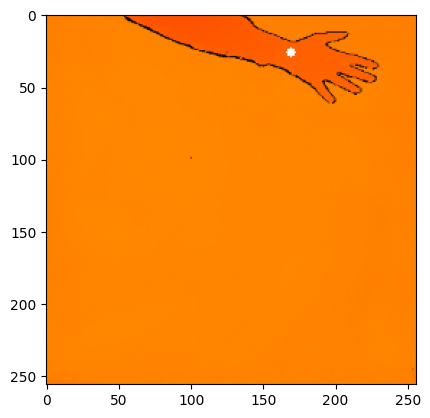

In [9]:
im = data_val[22].copy()
predictions = model.predict(im.reshape(1, 256, 256, 3))

print(predictions)

x_pos = int(predictions[1][0][0])
y_pos = int(predictions[1][0][1])

for x in range(256):
    for y in range(256):
        if((x - x_pos)**2 + (y - y_pos)**2 < 10):
            im[y][x] = [255, 255, 255]

import matplotlib.pyplot as plt
plt.imshow(im)
plt.show()




In [10]:
import tf2onnx

tf2onnx.convert.from_keras(model, output_path="Hand_with_dropout.onnx")

(ir_version: 8
 producer_name: "tf2onnx"
 producer_version: "1.16.1 15c810"
 graph {
   node {
     input: "input_2"
     output: "model_1/conv2d_5/BiasAdd__8:0"
     name: "model_1/conv2d_5/BiasAdd__8"
     op_type: "Transpose"
     attribute {
       name: "perm"
       ints: 0
       ints: 3
       ints: 1
       ints: 2
       type: INTS
     }
   }
   node {
     input: "model_1/conv2d_5/BiasAdd__8:0"
     input: "model_1/conv2d_5/Conv2D/ReadVariableOp:0"
     input: "model_1/conv2d_5/BiasAdd/ReadVariableOp:0"
     output: "model_1/conv2d_5/BiasAdd:0"
     name: "model_1/conv2d_5/BiasAdd"
     op_type: "Conv"
     attribute {
       name: "dilations"
       ints: 1
       ints: 1
       type: INTS
     }
     attribute {
       name: "strides"
       ints: 1
       ints: 1
       type: INTS
     }
     attribute {
       name: "kernel_shape"
       ints: 3
       ints: 3
       type: INTS
     }
     attribute {
       name: "group"
       i: 1
       type: INT
     }
     domain:

[array([[6.1832433e-21, 2.9204644e-12, 1.0000000e+00]], dtype=float32), array([[157.28055, 219.2163 ]], dtype=float32)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


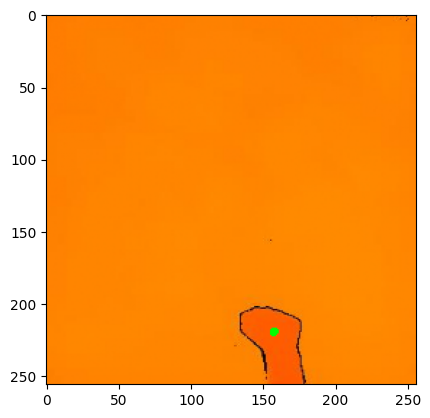

In [100]:
import onnxruntime
import matplotlib.pyplot as plt

img = Image.open("Data/JPG/Images/ClosedHand/11.jpg")
img = Bilinear(np.array(img), 256, 256)
img = img/255.0


# Load the ONNX model
sess = onnxruntime.InferenceSession("AIOv4.onnx")
intput_name = sess.get_inputs()[0].name
outputs = sess.get_outputs()
output_one = outputs[0].name
output_two = outputs[1].name
image = img.astype(np.float32)

onnx_predicted_label = sess.run(output_names=[output_one, output_two], input_feed={intput_name: image.reshape(1,256,256,3)})
print(onnx_predicted_label)

for x in range(256):
    for y in range(256):
        if((x - onnx_predicted_label[1][0][0])**2 + (y - onnx_predicted_label[1][0][1])**2 < 10):
            img[y][x] = [0, 255, 0]

plt.imshow(img)
plt.show()